In [9]:
# ✅ 1. 필요한 패키지 설치
!pip install -q scikit-learn

# ✅ 2. 라이브러리 import
import pandas as pd
import numpy as np
import random
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# ✅ 3. 직군별 과목 매핑 정의
job_categories = {
    "회로설계": ["회로이론", "전자회로", "아날로그회로", "고속디지털회로", "반도체소자",
             "PCB설계", "계측공학", "SPICE 시뮬레이션", "LTspice 실습", "전력전자회로"],
    "반도체 공정/소자": ["반도체소자", "반도체공정", "TCAD 시뮬레이션", "나노전자공학", "집적회로",
             "공정시뮬레이션", "물리전자", "재료공학", "소자물성", "전자기학"],
    "임베디드 시스템": ["마이크로프로세서", "임베디드 시스템", "C언어", "디지털회로", "ARM 시스템 설계",
              "IoT 실습", "RTOS", "MCU 응용설계", "하드웨어 인터페이스", "센서 응용"],
    "통신": ["통신이론", "디지털통신", "RF공학", "안테나공학", "위성통신",
           "신호및시스템", "무선통신", "통신시뮬레이션", "전파공학", "네트워크 프로토콜"],
    "자동차/로봇": ["차량전자제어", "전장시스템", "로봇공학", "자율주행", "ADAS 시스템",
              "CAN 통신", "모터제어", "센서기반제어", "전기자동차 시스템", "실시간제어"],
    "제어/자동화": ["제어공학", "자동제어", "센서응용", "시스템제어", "디지털제어",
              "계측및제어", "공정제어", "PLC 프로그래밍", "산업자동화", "로봇제어"],
    "SW/AI": ["파이썬프로그래밍", "딥러닝", "머신러닝", "데이터분석", "임베디드AI",
           "알고리즘", "컴퓨터비전", "TensorFlow 실습", "신호처리", "IoT데이터분석"],
    "품질관리": ["품질관리", "신뢰성공학", "제품시험평가", "전자파적합성(EMC)", "KS/ISO 표준",
             "공학실험", "제품설계기초", "시험평가실습", "고장분석", "산업표준개론"]
}

course_to_jobs = defaultdict(list)
for job, courses in job_categories.items():
    for c in courses:
        course_to_jobs[c].append(job)

job_list = list(job_categories.keys())

# ✅ 4. 사용자 50명 설문 데이터 생성
names = [f"사용자{i+1}" for i in range(50)]
all_courses = list(course_to_jobs.keys())

def generate_random_project(courses):
    keywords = random.sample(courses, k=min(2, len(courses)))
    return "와 ".join(keywords) + " 관련 시스템 개발"

data_50 = []
for name in names:
    selected_courses = random.sample(all_courses, k=random.randint(3, 5))
    project = generate_random_project(selected_courses)
    data_50.append({
        '이름': name,
        '수강과목': selected_courses,
        '프로젝트': project
    })

df_50 = pd.DataFrame(data_50)

# ✅ 5. TF-IDF로 프로젝트 임베딩
tfidf_vectorizer = TfidfVectorizer(max_features=30)
project_texts_50 = df_50['프로젝트'].tolist()
tfidf_matrix_50 = tfidf_vectorizer.fit_transform(project_texts_50)
feature_names_50 = tfidf_vectorizer.get_feature_names_out()

# ✅ 6. 점수 계산 함수 (가중치 적용)
def compute_score_50(row, alpha=2.0):
    score = defaultdict(float)
    for course in row['수강과목']:
        for job in course_to_jobs.get(course, []):
            score[job] += 5
    tfidf_row = tfidf_vectorizer.transform([row['프로젝트']]).toarray()[0]
    for i, tfidf_val in enumerate(tfidf_row):
        if i >= len(feature_names_50): continue
        keyword = feature_names_50[i]
        for job, keywords in job_categories.items():
            if any(k.lower() in keyword.lower() for k in keywords):
                score[job] += tfidf_val * 10 * alpha
    return score

# ✅ 7. 점수 계산 및 정규화 (100점 기준)
score_matrix_50 = []
for _, row in df_50.iterrows():
    score = compute_score_50(row)
    score_vector = [score.get(j, 0) for j in job_list]
    score_matrix_50.append(score_vector)

score_normalized_50 = []
for row in score_matrix_50:
    total = sum(row)
    normalized = [(s / total) * 100 if total > 0 else 0 for s in row]
    score_normalized_50.append(normalized)

# ✅ 8. 군집화 및 결과 결합
df_normalized_50 = pd.DataFrame(score_normalized_50, columns=job_list)
df_normalized_50 = pd.concat([df_50[['이름']], df_normalized_50], axis=1)

kmeans_50 = KMeans(n_clusters=5, random_state=42)
df_normalized_50['군집'] = kmeans_50.fit_predict(score_normalized_50)

# ✅ 9. 결과 출력
df_normalized_50.head(50)


,이름,회로설계,반도체 공정/소자,임베디드 시스템,통신,자동차/로봇,제어/자동화,SW/AI,품질관리,군집
0,사용자1,26.336355,0.000000,0.000000,60.495467,13.168178,0.000000,0.000000,0.000000,2
1,사용자2,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,2
2,사용자3,33.333333,0.000000,0.000000,0.000000,33.333333,33.333333,0.000000,0.000000,4
3,사용자4,15.048562,0.000000,0.000000,69.902877,0.000000,15.048562,0.000000,0.000000,2
4,사용자5,0.000000,0.000000,0.000000,0.000000,0.000000,33.333333,33.333333,33.333333,1
5,사용자6,15.048562,84.951438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6,사용자7,11.490574,11.490574,0.000000,0.000000,0.000000,65.528279,11.490574,0.000000,4
7,사용자8,13.954934,0.000000,44.180266,0.000000,27.909867,0.000000,0.000000,13.954934,3
8,사용자9,0.000000,0.000000,0.000000,53.731301,11.567175,11.567175,0.000000,23.134350,2
9,사용자10,45.897648,37.692944,0.000000,0.000000,0.000000,8.204704,8.204704,0.000000,0


/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.savefig(


from matplotlib import pyplot as plt
_df_0['회로설계'].plot(kind='hist', bins=20, title='회로설계')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49548 (\N{HANGUL SYLLABL

from matplotlib import pyplot as plt
_df_1['반도체 공정/소자'].plot(kind='hist', bins=20, title='반도체 공정/소자')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48288 (\N{HANGUL SYLLABLE BE}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46356 (\N{HANGUL SYLLABLE DI}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU

from matplotlib import pyplot as plt
_df_2['임베디드 시스템'].plot(kind='hist', bins=20, title='임베디드 시스템')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.savefig(


from matplotlib import pyplot as plt
_df_3['통신'].plot(kind='hist', bins=20, title='통신')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='회로설계', y='반도체 공정/소자', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49548 (\N{HANGUL SYLLABL

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='반도체 공정/소자', y='임베디드 시스템', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48288 (\N{HANGUL SYLLABLE BE}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46356 (\N{HANGUL SYLLABLE DI}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='임베디드 시스템', y='통신', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='통신', y='자동차/로봇', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.savefig(


from matplotlib import pyplot as plt
_df_8['회로설계'].plot(kind='line', figsize=(8, 4), title='회로설계')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49548 (\N{HANGUL SYLLABL

from matplotlib import pyplot as plt
_df_9['반도체 공정/소자'].plot(kind='line', figsize=(8, 4), title='반도체 공정/소자')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48288 (\N{HANGUL SYLLABLE BE}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46356 (\N{HANGUL SYLLABLE DI}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU

from matplotlib import pyplot as plt
_df_10['임베디드 시스템'].plot(kind='line', figsize=(8, 4), title='임베디드 시스템')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.savefig(


from matplotlib import pyplot as plt
_df_11['통신'].plot(kind='line', figsize=(8, 4), title='통신')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

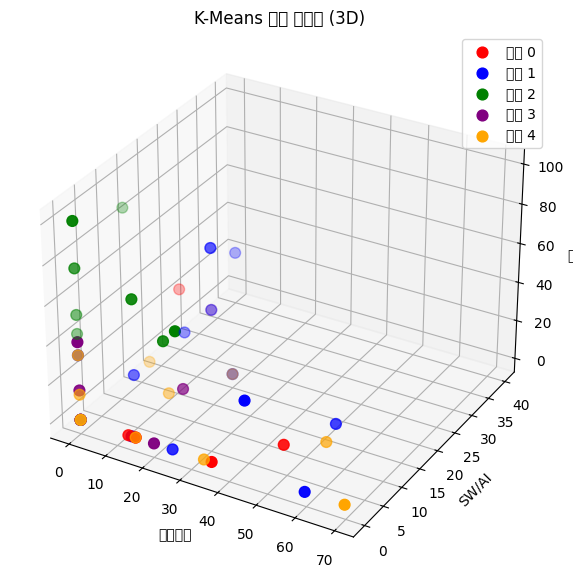

In [11]:
# ✅ 10. 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ✅ 시각화에 사용할 대표 직군 3개 선택
x_feature = '회로설계'
y_feature = 'SW/AI'
z_feature = '통신'

# ✅ 3D 산점도 그리기
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 각 군집별 색상과 레이블
colors = ['red', 'blue', 'green', 'purple', 'orange']
labels = [f"군집 {i}" for i in range(5)]

for cluster in range(5):
    subset = df_normalized_50[df_normalized_50['군집'] == cluster]
    ax.scatter(
        subset[x_feature],
        subset[y_feature],
        subset[z_feature],
        c=colors[cluster],
        label=labels[cluster],
        s=60
    )

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)
ax.set_title("K-Means 군집 시각화 (3D)")
ax.legend()
plt.show()



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44400 (\N{HANGUL SYLLABLE GUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51665 (\N{HANGUL SYLLABLE JIB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

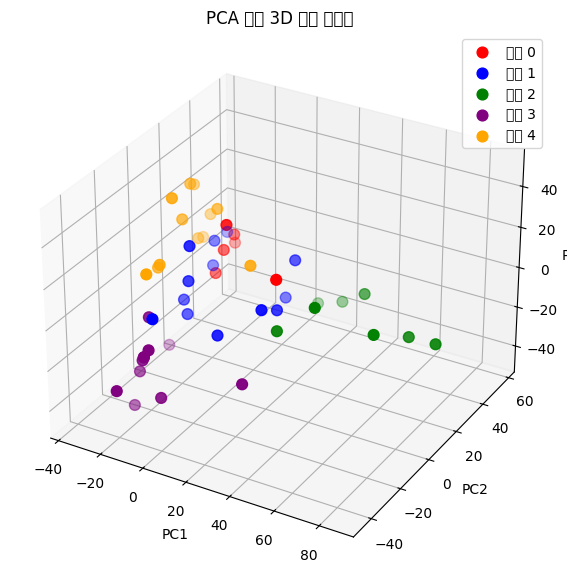

In [12]:
# ✅ 8. PCA 3차원 축소 + 시각화
X = df_normalized_50[job_list].values
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'blue', 'green', 'purple', 'orange']
labels = [f"군집 {i}" for i in range(5)]

for cluster in range(5):
    indices = df_normalized_50['군집'] == cluster
    ax.scatter(
        X_pca[indices, 0],
        X_pca[indices, 1],
        X_pca[indices, 2],
        c=colors[cluster],
        label=labels[cluster],
        s=60
    )

ax.set_title("PCA 기반 3D 군집 시각화")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()
